# BDT

This Jupyter Notebook contains the BDT used for separating the muon neutrino and muon anti-neutrino in the mixed sample containing $\nu_{\mu} + \bar{\nu}_{\mu}$. 

Input taking the .hdr5 files containing the Pandas dataframes for the selected sample.

### Input, importing the selected sample stored into .hdr5 file

In [1]:
#====================#
#  Import Packages   #
#====================#

import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot3 as uproot

# BDT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight
import joblib
import xgboost as xgb
from matplotlib.pylab import rcParams

In [2]:
#=====================================================================#
#  Import dataframes containing sample of mostly mixed numu anti-numu #
#=====================================================================#


df_mc = pd.read_hdf('dfs/df_run1_mc_mixed_numu_numubar.hdf5')
df_beam_on = pd.read_hdf('dfs/df_run1_data_mixed_numu_numubar.hdf5')
df_dirt = pd.read_hdf('dfs/df_run1_dirt_mixed_numu_numubar.hdf5')
df_ext = pd.read_hdf('dfs/df_run1_ext_mixed_numu_numubar.hdf5')

In [3]:
#==================================#
# Auxiliary functions used for BDT #
#==================================#


def label_signal(df_):
    # this function labels the sample, =1 for signal (numuCC events), and =0 for background (otherwise) # flip definition
      
    condition_numubar = (df_['truth_nuPdg']==-14)
    condition_numu = (df_['truth_nuPdg']==14)
    condition_cc = (df_['truth_isCC']==1)
    
    query_numubarcc = condition_numubar & condition_cc
    query_numucc = condition_numu & condition_cc
    
    df_["bdt_numubarcc_label"] = df_.apply(lambda row:1 if query_numubarcc[row.name] else 0, axis=1)
    df_["bdt_numucc_label"] = df_.apply(lambda row:1 if query_numucc[row.name] else 0, axis=1)
    
    #Calculate the percentage of 1's
    percentage_signal_numu = (df_["bdt_numucc_label"].sum() / len(df_)) * 100
    print(f"Labelled dataset. Portion of signal numuCC events in this sample: {percentage_signal_numu:.2f}%")
    
    percentage_signal_numubar = (df_["bdt_numubarcc_label"].sum() / len(df_)) * 100
    print(f"Labelled dataset. Portion of signal numubarCC events in this sample: {percentage_signal_numubar:.2f}%")
    
def remove_background_events(df_):
    # remove any event that is not nueCC/nuebarCC
    query = "(truth_nuPdg==14 | truth_nuPdg==-14) & truth_isCC==1"
    num_events_before = len(df_)
    df_.query(query, inplace=True) # keep only events where query=True
    contaminant_contribution = (num_events_before - len(df_))/num_events_before
    print(f"Removed {num_events_before - len(df_)} contaminants from the selection sample. This"
          f" constitutes {contaminant_contribution:.2%} of the sample.")

## BDT Training

In [4]:
# Rename dataframe, allowing df_bdt to be other things in the future
df_bdt = df_mc

# Label the sample provided, include "bdt_numubarcc_label" and "bdt_numucc_label"
label_signal(df_bdt)

# Remove remaining background (everything different than nueCC/nuebarCC)
remove_background_events(df_bdt)

# Calculate extra variables
#calc_vertex_dist(df_bdt)
#calc_costheta(df_bdt)

# ============================

chosen_var = 'bdt_numucc_label' # numucc=signal, numubarcc=background

# ============================

# List of variables used for training
#training_variables = ['muonvtx_diff','gap_energy','gap_flag_single_shower','gap_flag','reco_showerKE', 'cos_theta']
training_variables = ['Num_Proton', 'Num_Neutron', 'Num_Gamma', 'Num_Muon', 'Num_Electron',
                      'muonvtx_diff', 'kine_reco_Enu', 'muon_energy','cos_theta']
# training_variables = ['Num_Proton', 'Num_Neutron', 'Num_Muon', 'Num_Electron',
#                       'muonvtx_diff', 'kine_reco_Enu', 'muon_energy','cos_theta']

# Split the dataset into training and validation sets - using random_state as handle on the randomness of data
features = df_bdt[training_variables]
targets = df_bdt[chosen_var]

# Compute sample weights to balance the class distribution
sample_weights = compute_sample_weight(class_weight="balanced", y=targets)
features_train, features_test, targets_train, targets_test, sample_weights_train, sample_weights_test = train_test_split(features, targets, sample_weights, test_size=0.2, random_state=0)

features_test_sig = features_test[targets_test==1]
features_test_bkg = features_test[targets_test==0]

#Calculate the scale by which to increase the gradient for minority class examples
#scale = minority_gradient_scaler(df_bdt.copy())
#scale = 1
#print('Scaling minority class events by factor = %.2e' % scale)


Labelled dataset. Portion of signal numuCC events in this sample: 74.07%
Labelled dataset. Portion of signal numubarCC events in this sample: 17.05%
Removed 2264 contaminants from the selection sample. This constitutes 8.88% of the sample.


### Use GridSearchCV to check for the best hyper-parameters

In [5]:
lock1 = False
if lock1==True:
    xgb_dic={
        'n_estimators':[50,100,300,400,500],
        'max_depth': [3,5,10,15],
        'eta': [0.01,0.05,0.1,0.5,1.]
        }

    # Deine BDT object
    xgb_classifier = xgb.XGBClassifier()

    grid = GridSearchCV(xgb_classifier, xgb_dic, n_jobs=5)
    grid.fit(features_train, targets_train)

    print(f"The best score is \t{grid.best_score_}")
    print(f"The best parameters are \t{grid.best_params_}")

    results = pd.DataFrame.from_dict(grid.cv_results_)

### Training the model

In [6]:
# Create an XGBoost classifier (we should play with these parameters)
clf = xgb.XGBClassifier(n_estimators=100, # 100
                        eta=0.1, # 0.01
                        max_depth=3, # 5
                        scale_pos_weight=1, 
                        eval_metric=["error","auc", "logloss"],
                        objective = 'binary:logistic',
                        use_label_encoder=False # removes warning
                       )

# Train the classifier on our newly constructed dataset
eval_set = [(features_train, targets_train), (features_test, targets_test)]
clf.fit(features_train, targets_train, sample_weight=sample_weights_train, eval_set=eval_set)

# ============================

# Calculate bdt score
df_bdt.loc[:,chosen_var] = clf.predict_proba(df_bdt[training_variables])[:,1]


[0]	validation_0-error:0.34519	validation_0-auc:0.72928	validation_0-logloss:0.67796	validation_1-error:0.34761	validation_1-auc:0.73433	validation_1-logloss:0.67811
[1]	validation_0-error:0.31037	validation_0-auc:0.73151	validation_0-logloss:0.66534	validation_1-error:0.31446	validation_1-auc:0.73918	validation_1-logloss:0.66549
[2]	validation_0-error:0.34487	validation_0-auc:0.73470	validation_0-logloss:0.65489	validation_1-error:0.34675	validation_1-auc:0.74173	validation_1-logloss:0.65500
[3]	validation_0-error:0.34492	validation_0-auc:0.73860	validation_0-logloss:0.64617	validation_1-error:0.34675	validation_1-auc:0.74458	validation_1-logloss:0.64621
[4]	validation_0-error:0.34228	validation_0-auc:0.74011	validation_0-logloss:0.63880	validation_1-error:0.34309	validation_1-auc:0.74370	validation_1-logloss:0.63914
[5]	validation_0-error:0.33233	validation_0-auc:0.74113	validation_0-logloss:0.63252	validation_1-error:0.33470	validation_1-auc:0.74558	validation_1-logloss:0.63293
[6]	

### Printing out the decision tree

In [7]:
lock2 = False
if lock2==True: 
    rcParams['figure.figsize'] = (100,100)
    xgb.plot_tree(clf)
    plt.show()

### Printing out relevant evaluation metric

In [11]:
# Get the relevant information for printing

results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = np.linspace(0, epochs, 100, endpoint=True)

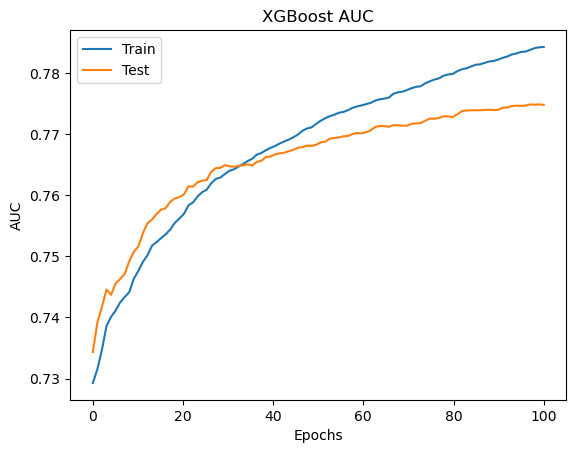

In [12]:
plt.plot(x_axis, results['validation_0']['auc'], label='Train')
plt.plot(x_axis, results['validation_1']['auc'], label='Test')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.title('XGBoost AUC')
plt.show()

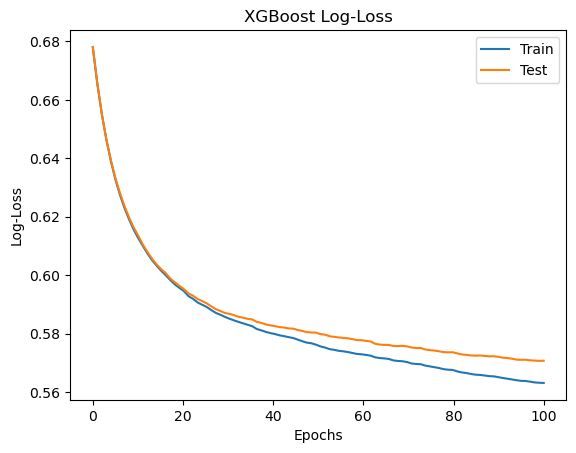

In [13]:
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.legend()
plt.ylabel('Log-Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log-Loss')
plt.show()

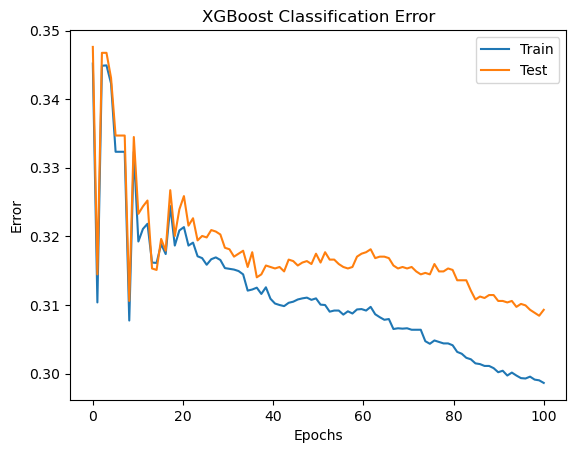

In [14]:
plt.plot(x_axis, results['validation_0']['error'], label='Train')
plt.plot(x_axis, results['validation_1']['error'], label='Test')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Error')
plt.show()

Extracting and Plotting ROC curve

In [15]:
from sklearn import metrics
def buildROC(target_test, test_preds, target_train, train_preds):
    fpr_test, tpr_test, _ = metrics.roc_curve(target_test, test_preds)
    fpr_train, tpr_train, _ = metrics.roc_curve(target_train, train_preds)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_test, tpr_test, label = 'Test - AUC = %0.2f' % roc_auc_test, color='g')
    plt.plot(fpr_train, tpr_train, label = 'Train - AUC = %0.2f' % roc_auc_train, color='b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [16]:
y_pred_proba_train = clf.predict_proba(features_train)
y_pred_proba_test = clf.predict_proba(features_test)

y_pred_proba_sig_train = clf.predict_proba(features_test_sig)
y_pred_proba_bkg_train = clf.predict_proba(features_test_bkg)
bdtScoreSigTrain = y_pred_proba_sig_train[:,-1]
bdtScoreBkgTrain = y_pred_proba_bkg_train[:,-1]
print(bdtScoreBkgTrain.shape)

(866,)


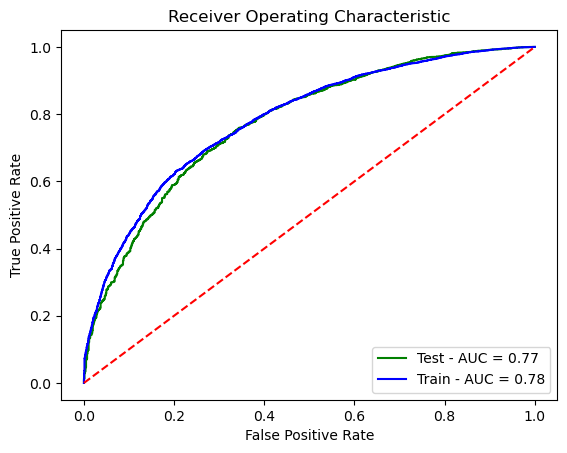

In [17]:
buildROC(targets_test, y_pred_proba_test[:, 1], targets_train, y_pred_proba_train[:, 1])

Feature Importance

In [18]:
def plot_important_features(features, feature_importances_, number):
    
    plt.close()
    plt.figure(figsize=(8,5))
    
    zipped = zip(features, feature_importances_)
    zipped_sort = sorted(zipped, key = lambda x:x[1], reverse=True)
    zipped_sort_reduced = zipped_sort[:number]
    
    res = [[ i for i, j in zipped_sort_reduced], 
           [ j for i, j in zipped_sort_reduced]]
    red_features = res[0]
    red_importances = res[1]
    
    plt.barh(range(len(red_importances)), red_importances, align='center')
    plt.yticks(np.arange(len(red_features)), red_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Top %i features"%(number))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
    plt.tight_layout()
    plt.show()
    
    return red_features

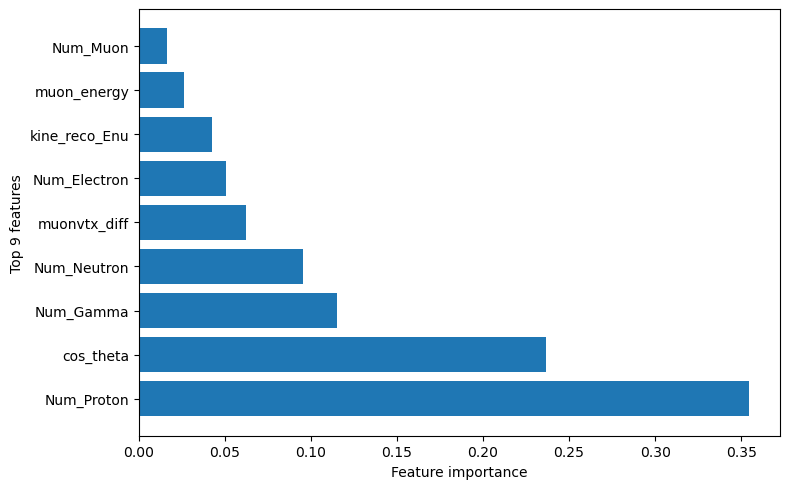

In [19]:
list_features = plot_important_features(training_variables, clf.feature_importances_, 9)

Plot the BDT Score Distribution

In [20]:
# First Calulate BDT score
df_bdt.loc[:,chosen_var] = clf.predict_proba(df_bdt[training_variables])[:,1]

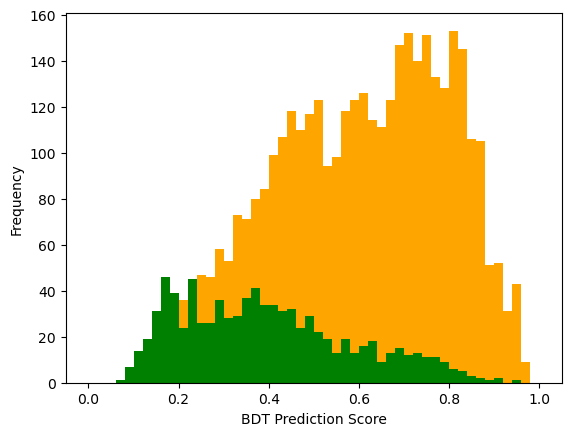

In [21]:
plt.hist(bdtScoreSigTrain, 50, color='orange', stacked=True, range=(0.,1.))
plt.hist(bdtScoreBkgTrain, 50, color='green', stacked=True, range=(0.,1.))
plt.xlabel("BDT Prediction Score")
plt.ylabel("Frequency")
plt.show()

In [22]:
cut = 0.76
signal_cut = bdtScoreSigTrain[bdtScoreSigTrain>=cut]
bkg_cut = bdtScoreBkgTrain[bdtScoreBkgTrain>=cut]

signal_cut_accuracy = signal_cut.size/(signal_cut.size+bkg_cut.size)
bkg_cut_accuracy = bkg_cut.size/(signal_cut.size+bkg_cut.size)
print("the sig accuracy %.3f and bkg accuracy is %.3f" % (signal_cut_accuracy, bkg_cut_accuracy))
print(signal_cut.size)
print(bkg_cut.size)
print(bdtScoreSigTrain.size)

the sig accuracy 0.960 and bkg accuracy is 0.040
956
40
3780


In [ ]:
# plot signal and background separately
# plt.figure();
# plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
#          histtype='step',color='midnightblue',label='signal');
# plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
#          histtype='step',color='firebrick',label='background');
# # make the plot readable
# plt.xlabel('Prediction from BDT',fontsize=12);
# plt.ylabel('Events',fontsize=12);
# plt.legend(frameon=False);

## Plotting Particle Multiplicity